In [33]:
# Building a basic selector ML algorithm for picking simulation strategy with inferQ data

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import * 

In [54]:
PRIMARY_KEY = "RowKey"
qiskit_sim = pd.read_csv("data_clean_sim_auto_worked_qiskit.csv")
inferq_features = pd.read_csv("data_clean_features.csv")
df_dropped = pd.merge(qiskit_sim, inferq_features, on=PRIMARY_KEY, how="inner")

cols = df_dropped.columns.tolist()
# let us remove some columns that we do not need
DROP_COLS = [
    "blob_url",
    "RowKey",
    "PartitionKey",
    "name",
    "serialization_method",
    "qpy_serialization_success",
    "gate_counts",
    "automatic_method"
]

ALL_METHODS = [
    "statevector_saved",
    "statevector",
    "stabilizer",
    "density_matrix",
    "matrix_product_state",
    "extended_stabilizer",
    "unitary",
    "automatic"
]

DROP_FAILED_SIM = [
    f"{m}_{suffix}"
    for m in ALL_METHODS
    for suffix in (
        "transpiled_size",
        "transpiled_depth",
        "memory_usage",
        "execution_time",
        "gate_counts",
    )
]

FEATURES = [c for c in df_dropped.drop(columns=DROP_COLS).columns.tolist() if c not in DROP_FAILED_SIM]

METHODS = [
    "statevector_saved",
    # "statevector",
    # "stabilizer",
    "density_matrix",
    "matrix_product_state",
    "extended_stabilizer",
    # "unitary",
    # "automatic"
]

print(FEATURES)
print(len(df_dropped))

['average_clustering_coefficient', 'average_degree', 'average_shortest_path_length', 'central_point_of_dominance', 'circuit_size', 'density_score', 'depth', 'diameter', 'edge_count', 'idling_score', 'locality_ratio', 'max_degree', 'min_cut_upper', 'num_qubits', 'pauli_gate_count', 'radius', 'statevector_saved_entropy', 'statevector_saved_sparsity', 'std_dev_adjacency_matrix', 'two_qubit_gate_count', 'two_qubit_gate_percentage', 'width']
45376


In [55]:
def best_method(row):
    costs = {}
    for m in METHODS:
        t = row.get(f"{m}_execution_time")
        mem = row.get(f"{m}_memory_usage")
        if pd.isna(t) or pd.isna(mem):
            continue
        costs[m] = t
    return min(costs, key=costs.get) if costs else np.nan

df_dropped["best_method"] = df_dropped.apply(best_method, axis=1)
df_clean = df_dropped.dropna(subset=["best_method"])
print(len(df_clean))

45376


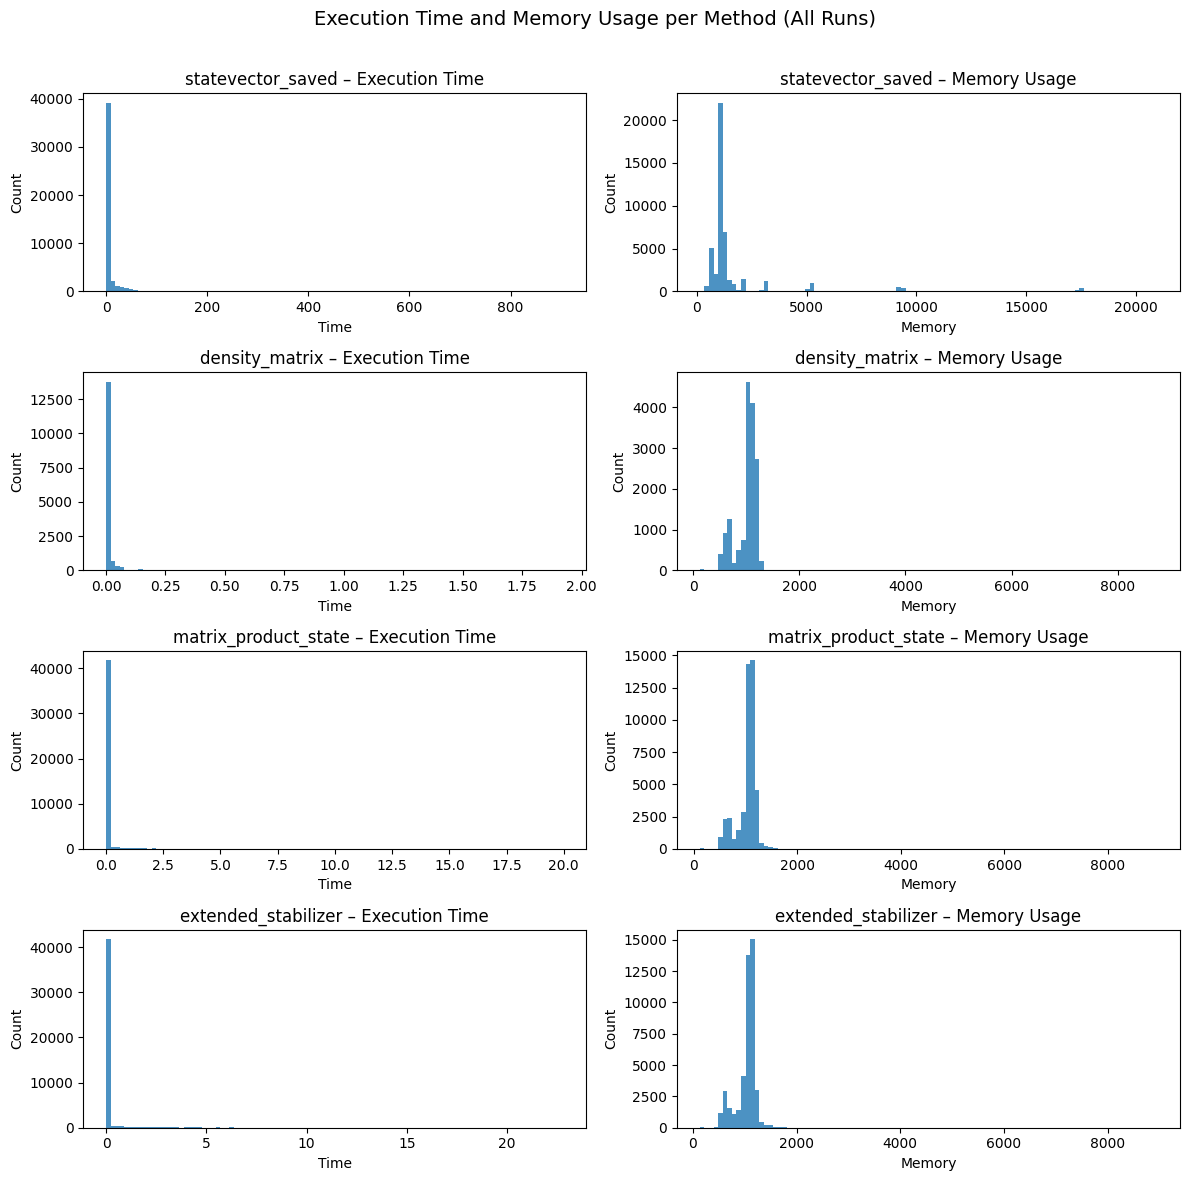

In [56]:
import matplotlib.pyplot as plt

methods = METHODS
n_methods = len(methods)

fig, axes = plt.subplots(
    nrows=n_methods,
    ncols=2,
    figsize=(12, 3 * n_methods),
    sharex=False,
    sharey=False
)

# Handle single-method edge case
if n_methods == 1:
    axes = axes.reshape(1, 2)

for i, m in enumerate(methods):
    # Execution time (ALL rows)
    time_col = f"{m}_execution_time"
    time_vals = df_clean[time_col].dropna()

    axes[i, 0].hist(time_vals, bins=100, alpha=0.8)
    axes[i, 0].set_title(f"{m} – Execution Time")
    axes[i, 0].set_xlabel("Time")
    axes[i, 0].set_ylabel("Count")

    # Memory usage (ALL rows)
    mem_col = f"{m}_memory_usage"
    mem_vals = df_clean[mem_col].dropna()

    axes[i, 1].hist(mem_vals, bins=100, alpha=0.8)
    axes[i, 1].set_title(f"{m} – Memory Usage")
    axes[i, 1].set_xlabel("Memory")
    axes[i, 1].set_ylabel("Count")

plt.suptitle("Execution Time and Memory Usage per Method (All Runs)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


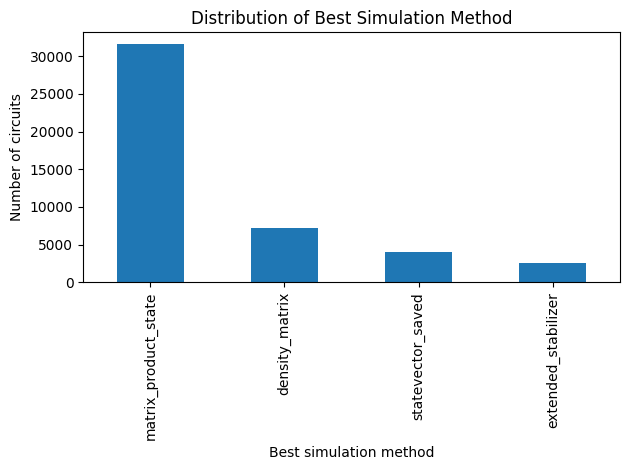

In [57]:
import matplotlib.pyplot as plt

df_clean["best_method"].value_counts().plot(kind="bar")

plt.xlabel("Best simulation method")
plt.ylabel("Number of circuits")
plt.title("Distribution of Best Simulation Method")
plt.tight_layout()
plt.show()


In [58]:
total = len(df_clean)
print(df_clean["best_method"].value_counts())
print(len(df_clean))
print(df_clean["best_method"].value_counts()/total)

best_method
matrix_product_state    31570
density_matrix           7183
statevector_saved        4020
extended_stabilizer      2603
Name: count, dtype: int64
45376
best_method
matrix_product_state    0.695742
density_matrix          0.158300
statevector_saved       0.088593
extended_stabilizer     0.057365
Name: count, dtype: float64


average_clustering_coefficient
average_degree
average_shortest_path_length
central_point_of_dominance
circuit_size
density_score
depth
diameter
edge_count
idling_score
locality_ratio
max_degree
min_cut_upper
num_qubits
pauli_gate_count
radius
statevector_saved_entropy
statevector_saved_sparsity
std_dev_adjacency_matrix
two_qubit_gate_count
two_qubit_gate_percentage
width
average_clustering_coefficient
average_degree
average_shortest_path_length
central_point_of_dominance
circuit_size
density_score
depth
diameter
edge_count
idling_score
locality_ratio
max_degree
min_cut_upper
num_qubits
pauli_gate_count
radius
statevector_saved_entropy
statevector_saved_sparsity
std_dev_adjacency_matrix
two_qubit_gate_count
two_qubit_gate_percentage
width
average_clustering_coefficient
average_degree
average_shortest_path_length
central_point_of_dominance
circuit_size
density_score
depth
diameter
edge_count
idling_score
locality_ratio
max_degree
min_cut_upper
num_qubits
pauli_gate_count
radius
statevect

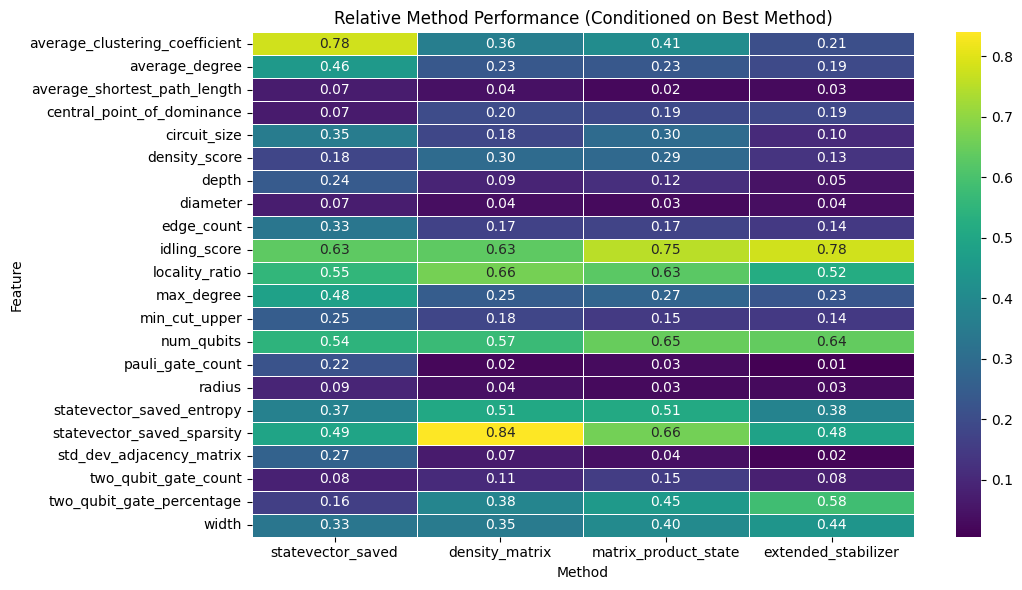

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

matrix = pd.DataFrame(index=FEATURES, columns=METHODS, dtype=float)

for method in METHODS:
    subset = df_clean[df_clean["best_method"] == method]
    for feature in FEATURES:
        print(feature)
        mx, mi = subset[feature].max(),subset[feature].min()
        if mx - mi > 0:
            matrix.loc[feature, method] = (subset[feature].mean()-mi)/(mx-mi)
        else:
            matrix.loc[feature, method] = 0.0

# --- Min–max normalize per feature (row-wise) ---
matrix_norm = matrix.copy()

# --- Plot heatmap ---
plt.figure(figsize=(11, 6))
sns.heatmap(
    matrix_norm,
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=0.5
)

plt.title("Relative Method Performance (Conditioned on Best Method)")
plt.xlabel("Method")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Best Method Histograms

In [60]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from utils import *

# plot_best_method_hists(METHODS, FEATURES, df_clean)


In [61]:
X = df_clean[FEATURES].select_dtypes(include=[np.number])
y = df_clean["best_method"]

# PCA 

# Random Forest 

In [62]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

TARGET = "best_method"
RANDOM_STATE = 42

X = df_clean[FEATURES]
y = df_clean[TARGET]

y_original = df_clean[TARGET]


X_train, X_test, y_train, y_test, y_orig_train, y_orig_test = train_test_split(
    X, y, y_original,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)
y.value_counts(normalize=True)


best_method
matrix_product_state    0.695742
density_matrix          0.158300
statevector_saved       0.088593
extended_stabilizer     0.057365
Name: proportion, dtype: float64

                      precision    recall  f1-score   support

   statevector_saved       0.93      0.87      0.90       804
      density_matrix       0.54      0.52      0.53      1437
matrix_product_state       0.85      0.88      0.87      6314
 extended_stabilizer       0.60      0.47      0.53       521

            accuracy                           0.80      9076
           macro avg       0.73      0.69      0.71      9076
        weighted avg       0.80      0.80      0.80      9076



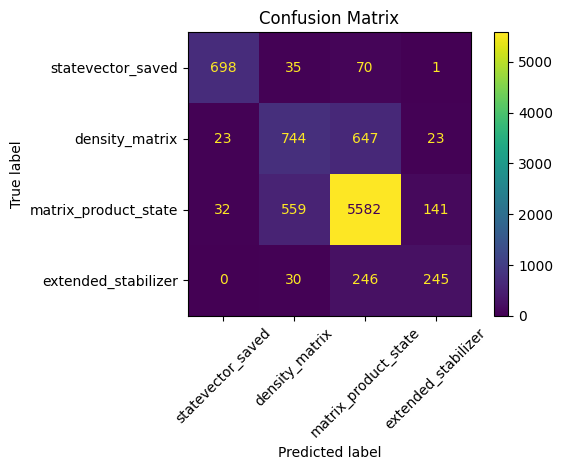

In [63]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=10,
    n_jobs=-1,
    # class_weight="balanced",
    random_state=RANDOM_STATE
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(
    y_test, y_pred,
    labels=METHODS,
    target_names = METHODS
))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    labels=METHODS,
    xticks_rotation=45
)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# XG Boost

                      precision    recall  f1-score   support

      density_matrix       0.54      0.55      0.54      1437
 extended_stabilizer       0.59      0.49      0.53       521
matrix_product_state       0.86      0.88      0.87      6314
   statevector_saved       0.93      0.89      0.91       804

            accuracy                           0.80      9076
           macro avg       0.73      0.70      0.71      9076
        weighted avg       0.80      0.80      0.80      9076



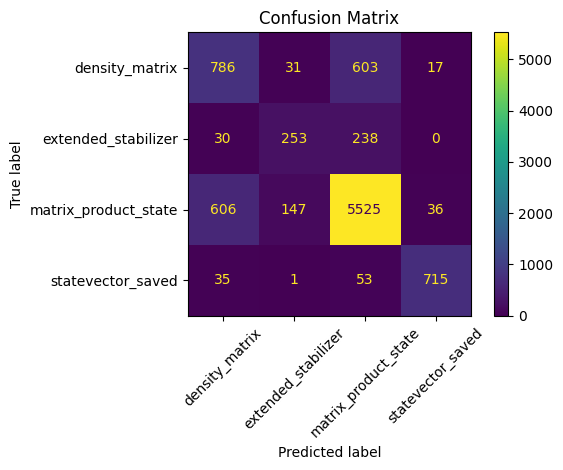

In [64]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

num_classes = len(le.classes_)

model = XGBClassifier(
    n_estimators=400,
    max_depth=12,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=10,
    objective="multi:softmax",   # softmax since we want class labels
    num_class=num_classes,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    eval_metric="mlogloss"
)

model.fit(X_train, y_train_enc)

y_pred_enc = model.predict(X_test)

y_pred = le.inverse_transform(y_pred_enc)

print(classification_report(
    y_test,
    y_pred,
    labels=le.classes_,
    target_names=le.classes_
))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    labels=le.classes_,
    xticks_rotation=45
)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

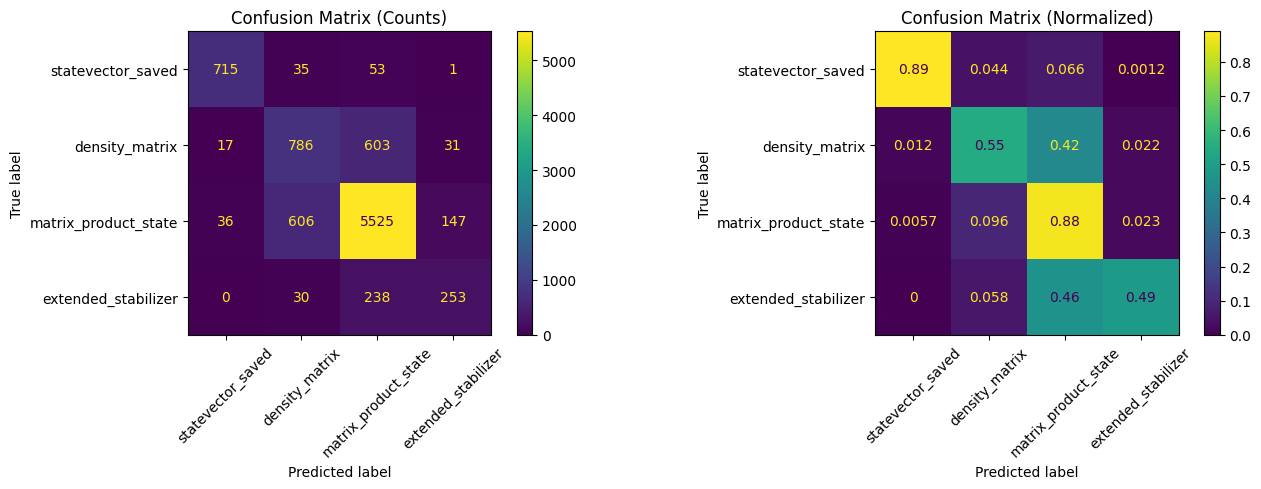

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    labels=METHODS,
    display_labels=METHODS,
    ax=axes[0],
    xticks_rotation=45,
    normalize=None
)
axes[0].set_title("Confusion Matrix (Counts)")

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    labels=METHODS,
    display_labels=METHODS,
    ax=axes[1],
    xticks_rotation=45,
    normalize="true"
)
axes[1].set_title("Confusion Matrix (Normalized)")

plt.tight_layout()
plt.show()


# SVC 

In [66]:
print(X_train.isna().sum().sort_values(ascending=False))

average_clustering_coefficient    0
average_degree                    0
average_shortest_path_length      0
central_point_of_dominance        0
circuit_size                      0
density_score                     0
depth                             0
diameter                          0
edge_count                        0
idling_score                      0
locality_ratio                    0
max_degree                        0
min_cut_upper                     0
num_qubits                        0
pauli_gate_count                  0
radius                            0
statevector_saved_entropy         0
statevector_saved_sparsity        0
std_dev_adjacency_matrix          0
two_qubit_gate_count              0
two_qubit_gate_percentage         0
width                             0
dtype: int64


                      precision    recall  f1-score   support

      density_matrix       0.49      0.71      0.58      1437
 extended_stabilizer       0.36      0.55      0.43       521
matrix_product_state       0.91      0.76      0.83      6314
   statevector_saved       0.71      0.84      0.76       804

            accuracy                           0.75      9076
           macro avg       0.62      0.71      0.65      9076
        weighted avg       0.80      0.75      0.76      9076



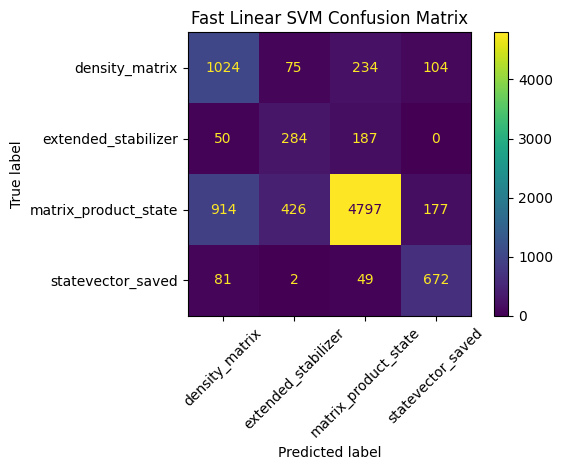

In [67]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(
        C=10.0,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        max_iter=5000
    ))
])

model.fit(X_train, y_train_enc)

y_pred_enc = model.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

print(classification_report(
    y_test,
    y_pred,
    labels=le.classes_,
    target_names=le.classes_
))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    labels=le.classes_,
    xticks_rotation=45
)
plt.title("Fast Linear SVM Confusion Matrix")
plt.tight_layout()
plt.show()


In [68]:
# Now let us compare against the accuracy of automatic
METHODS.append("automatic")

df_auto = df_dropped
print(len(df_auto))

df_auto["best_method"] = df_auto.apply(best_method, axis=1)
df_auto = df_auto.dropna(subset=["best_method"])

total = len(df_auto)

counts = df_auto["best_method"].value_counts()
percentages = counts / total * 100
summary_df = pd.DataFrame({
    "count": counts,
    "percentage": percentages
})
print(summary_df)
METHODS.remove("automatic")

45376
                      count  percentage
best_method                            
automatic             23466   51.714563
matrix_product_state  16080   35.437236
density_matrix         4422    9.745240
extended_stabilizer    1262    2.781206
statevector_saved       146    0.321756
